<h1 style="text-align:center;">Waste Classification - CNN - Keras & Tensorflow <h1>

## @Author: Group 1 - AWT306

Lu Quoc Khai Ho - A00096112

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import warnings
warnings.filterwarnings('ignore')
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image


# Model Hypertunning
!pip install -q keras_tuner
import keras_tuner as kt

import tensorflow as tf

# Fig GPU registration
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.config.list_physical_devices('GPU')
import keras


from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# tf.config.optimizer.set_jit(True) # optimize keras trainning process

2024-12-01 16:33:10.067083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 16:33:10.090057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 16:33:10.090088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Defining variables and reusable functions

In [2]:
# Define dataset folder
current_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir =  current_dir + "/dataset"

# Set the testing directory path for model prediction
testing_dir = current_dir + "/test"

In [3]:
image_count = len(glob.glob(f'{data_dir}/*/*'))
print(f"Total images: {image_count}") # Count total images in dataset folder

Total images: 7000


### Visualize trainning result

In [4]:
def visualize_training_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"],label = "Train Loss")
    plt.plot(history.history["val_loss"],label = "Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Load data using a Keras utility

## Generate more dataset

This function is used to generate the images for the mall dataset which uses the same method with data augmentation and save data to each label folder

In [5]:
#generate images from existed dataset
def generate_dataset_image(dataset_path, number_images):
    print("Images are generating... ")
    datagen = ImageDataGenerator(
            rotation_range=40,
            height_shift_range=0.1,
            width_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
    )
    
#     subfolders = glob.glob(f"{dataset_path}/*")
    
#     labels = []
    
#     for path in subfolders:
#         label = path.split("/")[-1]
#         files = glob.glob(f"{path}/*")
#         j = 0
#         for file in files:
#             img = keras.utils.load_img(file)  # this is a PIL image
#             x = keras.utils.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
#             x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
#             # the .flow() command below generates batches of randomly transformed images
#             # and saves the results to the `preview/` directory
#             i = 0
#             for batch in datagen.flow(x, batch_size=1,
#                                       save_to_dir=f'{dataset_path}/{label}', save_prefix=f'generated.{j}.{label}', save_format='jpeg'):
#                 i += 1
#                 if i > (number_images - 1): # generate 1 image 3 times
#                     break  # otherwise the generator would loop indefinitely
#             j += 1
            
    label = "unknown"
    files = glob.glob(f"{dataset_path}/{label}/*")
    j = 0
    for file in files:
        img = keras.utils.load_img(file)  # this is a PIL image
        x = keras.utils.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `preview/` directory
        i = 0
        for batch in datagen.flow(x, batch_size=1,
                                  save_to_dir=f'{dataset_path}/{label}', save_prefix=f'generated.{j}.{label}', save_format='jpeg'):
            i += 1
            if i > (number_images - 1): # generate 1 image 3 times
                break  # otherwise the generator would loop indefinitely
        j += 1
        
    print("Images generating is completed!")


In [6]:
# generate_dataset_image(data_dir, 6)

In [7]:
image_count = len(glob.glob(f'{data_dir}/*/*'))
print(f"total images: {image_count}")

total images: 7000


### Define some parameters for the loader:

In [8]:
batch_size = 32

img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7000 files belonging to 5 classes.
Using 4900 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7000 files belonging to 5 classes.
Using 2100 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['glass', 'metal', 'paper', 'plastic', 'unknown']


## Visualize the data

Testing image that fit to the label in random 1 batch dataset

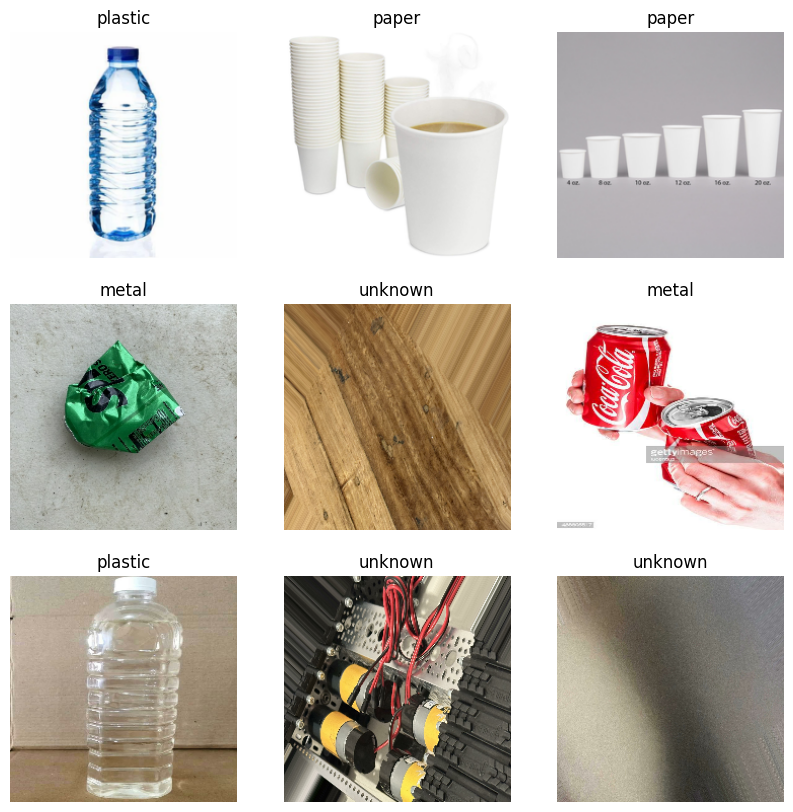

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Configure the dataset for performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Optimization for Training and Validation Datasets by caching and shuffling
# train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# prefetching the training data to optimize pipeline
# train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Standardize the data

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Overfitting Solutions

## 1. Data augmentation

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# # Apply data_augmentation to the training images.
# train_ds = train_ds.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf.data.AUTOTUNE,
# )
# # Prefetching samples in GPU memory helps maximize GPU utilization.
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

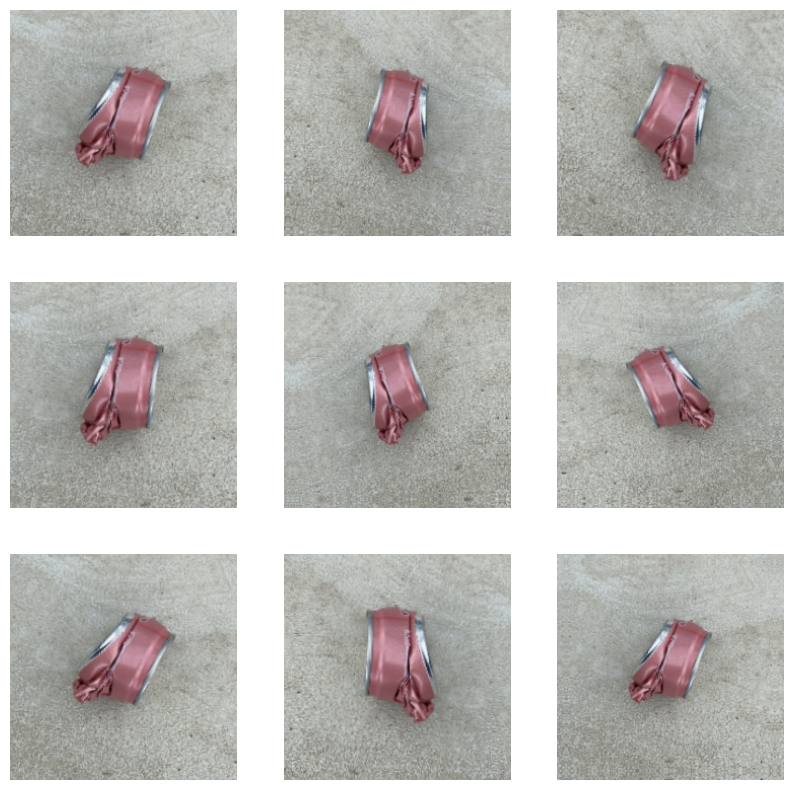

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
# dropout_rate = 0.3


# model = Sequential([
#     base_model,
#     data_augmentation,
#     layers.Rescaling(1./255),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(128, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(dropout_rate),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(dropout_rate),
    
#     layers.Dense(120, activation='relu'),
    
#     layers.Dropout(dropout_rate),
    
#     layers.Dense(num_classes, name="outputs")
# ])

In [44]:
dropout_rate = 0.4
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

model = Sequential([
    data_augmentation,
#     layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu',  kernel_initializer='he_normal'),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, name="outputs")
])

In [45]:

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
#     optimizer='adam',
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [47]:
epochs=100
early_stopping = keras.callbacks.EarlyStopping( monitor='val_loss',          
    mode='min',                   
    min_delta=0.01,              
    verbose=1,                    
    patience=10,                 
    restore_best_weights=True     
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4827 - loss: 1.3924 - val_accuracy: 0.6505 - val_loss: 0.8695
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6705 - loss: 0.8738 - val_accuracy: 0.6633 - val_loss: 0.8651
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7206 - loss: 0.7359 - val_accuracy: 0.7233 - val_loss: 0.7237
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7467 - loss: 0.6755 - val_accuracy: 0.6729 - val_loss: 0.8184
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7633 - loss: 0.6398 - val_accuracy: 0.7338 - val_loss: 0.7167
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7715 - loss: 0.6216 - val_accuracy: 0.7333 - val_loss: 0.7218
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7828 - loss: 0.5878 - val_accuracy: 0.7381 - val_loss: 0.6851
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7934 - loss: 0.5711 - 

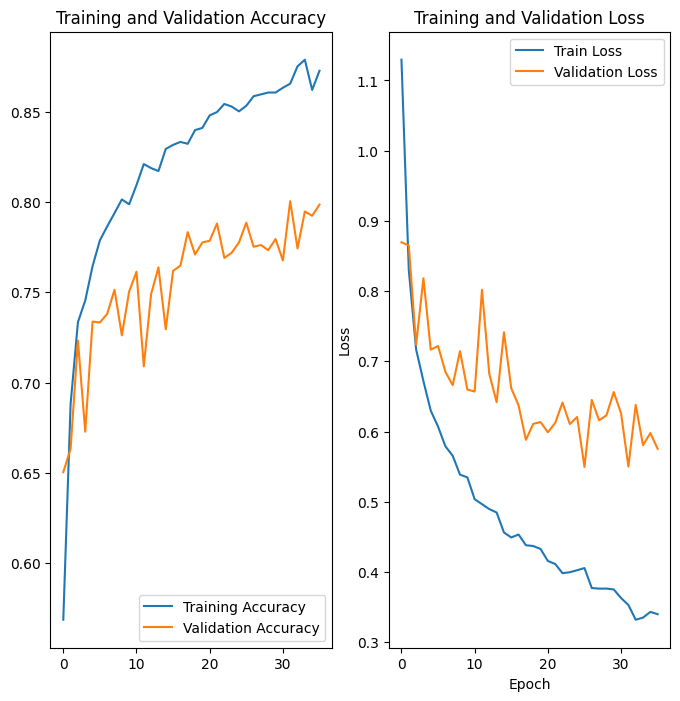

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"],label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save Keras model

In [31]:
model.save(f'{current_dir}/AWT306_Group1_CNN_Model.keras')
# model.export('model_export')

## MobileNetV2 Hypertuning

In [32]:
LEARNING_RATE = 1e-3
# dropout_rate = 0.5
# LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
METRICS = ['accuracy']

def build_model(hp):
    
    # Define all hyperparms
    mobilenet = MobileNetV2(input_shape=(img_height,img_width,3), weights='imagenet', include_top=False)
    mobilenet.trainable = False
    n_layers = hp.Choice('n_layers', [ 1, 2, 3])
    dropout_rate = hp.Choice('rate', [ 0.25, 0.4, 0.5])
    n_units = hp.Choice('units', [128, 256, 512])
    learning_rate = hp.Choice('lr', [LEARNING_RATE, LEARNING_RATE * 0.1, LEARNING_RATE*0.01])
    
    # Mode architecture
    model = Sequential([
#         data_augmentation,
        mobilenet,
        layers.GlobalAveragePooling2D(),
    ])
    
    # Add hidden/top layers 
    for _ in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu', kernel_initializer='he_normal'))
    
    # Add Dropout Layer
    model.add(layers.Dropout(dropout_rate))
    
    # Output Layer
#     model.add(layers.Dense(num_classes, activation='softmax'))
    model.add(layers.Dense(num_classes))
    
    # Compile the model
    model.compile(
        loss=LOSS,
        optimizer = keras.optimizers.Adam(learning_rate),
        metrics = METRICS
    )
    
    # Return model
    return model

In [33]:
# Initialize Random Searcher
random_searcher = kt.RandomSearch(
    hypermodel=build_model, 
    objective='val_loss', 
    max_trials=40, 
    seed=42, 
    project_name="MobileNetSearch", 
    loss=LOSS)

# Start Searching
search = random_searcher.search(
    train_ds,
    validation_data=val_ds,
    epochs = epochs,
    batch_size = batch_size
)

Reloading Tuner from ./MobileNetSearch/tuner0.json


In [34]:
# Best Hyper params
best_hps = random_searcher.get_best_hyperparameters()[0]
print(f"Best Hyper Params founded: {best_hps.values}\n")

Best Hyper Params founded: {'n_layers': 1, 'rate': 0.4, 'units': 256, 'lr': 0.0001}



In [35]:
# Build the best model
mobile_net_model = build_model(best_hps)
mobile_net_model.summary()

# Compile the model
print("\nTraining Best Model Architecture : ")
early_stopping = keras.callbacks.EarlyStopping( 
    monitor='val_loss',                            
    mode='min',                   
    min_delta=0.01,              
    verbose=1,                    
    patience=10,                 
    restore_best_weights=True        
)

mobile_net_model_history = mobile_net_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        early_stopping,
        keras.callbacks.ModelCheckpoint('AWT306_Group1_CNN_Best_Model.keras', save_best_only=True)
    ]
)

mobile_net_model.export('model_export')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Training Best Model Architecture : 
Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.3617 - loss: 1.5893 - val_accuracy: 0.6519 - val_loss: 0.9551
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6192 - loss: 1.0090 - val_accuracy: 0.7081 - val_loss: 0.8068
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6682 - loss: 0.8660 - val_accuracy: 0.7429 - val_loss: 0.7344
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7165 - loss: 0.7684 - val_accuracy: 0.7643 - val_loss: 0.6716
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7404 - loss: 0.7071 - val_accuracy: 0.7786 - val_loss: 0.6299
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7595 - loss: 0.6506 - val_accuracy: 0.7919 - val_loss: 0.5976
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7798 - loss: 0.6038 - val_accuracy: 0.8033 - val_loss: 0.5746
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/ste

154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9676 - loss: 0.1315 - val_accuracy: 0.8838 - val_loss: 0.3441
Epoch 51/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9695 - loss: 0.1227 - val_accuracy: 0.8848 - val_loss: 0.3423
Epoch 52/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9650 - loss: 0.1251 - val_accuracy: 0.8848 - val_loss: 0.3379
Epoch 52: early stopping
Restoring model weights from the end of the best epoch: 42.
INFO:tensorflow:Assets written to: model_export/assets


INFO:tensorflow:Assets written to: model_export/assets


Saved artifact at 'model_export'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_329')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139669455281616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139652251371120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139652251370064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139652251383792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139652251369536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139652251377808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139652251374288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139652251376400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139652251377104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139652251378512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13965225138044

## Visualise the best model training 

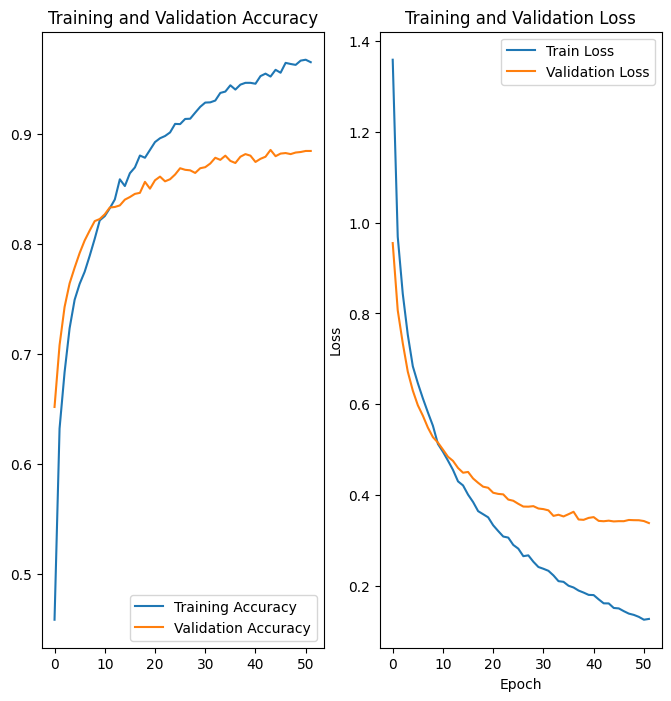

In [36]:
visualize_training_result(mobile_net_model_history)

## Load Keras Model

In [41]:
group1_cnn_model = tf.keras.models.load_model(f'{current_dir}/AWT306_Group1_CNN_Best_Model.keras', compile=False)

# Show the model architecture
group1_cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Predict on new data

In [42]:
import math
def resize_display_image(path, width):
    img = None
    if len(path):
        # Read the Image
        image = Image.open(path)
        ratio = (width/image.width)

        # Resize the image using resize() method
        image = image.resize((width, math.ceil(image.height * ratio)))
        
    return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
tf.Tensor([6.5604746e-01 6.1578222e-04 6.0172997e-02 2.8276134e-01 4.0241162e-04], shape=(5,), dtype=float32)
['glass', 'metal', 'paper', 'plastic', 'unknown']
This image most likely belongs to glass with a 65.60 percent confidence.


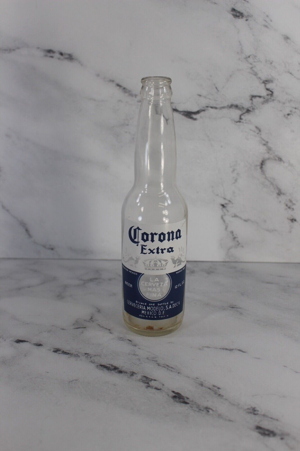

In [50]:
import random

animals = list(glob.glob(f'{testing_dir}/*'))

# Select a random item
#selected_item = random.choice(animals)
selected_item = testing_dir + '/corona-bottle.jpg'
img = tf.keras.utils.load_img(
    selected_item, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
# img_array = img_array/255.0

predictions = group1_cnn_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(class_names)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# PIL.Image.open(str(selected_item))
resize_display_image(str(selected_item),300)

## Convert the Keras Sequential model to a TensorFlow Lite model

In [51]:
print(mobile_net_model)

<Sequential name=sequential_1, built=True>


In [52]:
print(mobile_net_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,245,649 (12.38 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 658,444 (2.51 MB)

None


In [53]:
# Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(group1_cnn_model)
# # converter.target_spec.supported_ops = [
# #   tf.lite.OpsSet.TFLITE_BUILTINS, # enable LiteRT ops.
# #   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# # ]
# tflite_model = converter.convert()

# # Save the model.
# with open('converted_model.tflite', 'wb') as f:
#   f.write(tflite_model)

In [54]:
converter = tf.lite.TFLiteConverter.from_saved_model('model_export')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable LiteRT ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open(current_dir+"/raspberry_pi/awt306_model.tflite", "wb").write(tflite_model)

W0000 00:00:1733094341.448819   16586 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1733094341.448861   16586 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


10182248

# Run the TensorFlow Lite model

In [55]:
TF_MODEL_FILE_PATH = current_dir+'/raspberry_pi/awt306_model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [56]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_329'], 'outputs': ['output_0']}}

In [57]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [59]:
predictions_lite = classify_lite(keras_tensor_329=img_array)['output_0']
score_lite = tf.nn.softmax(predictions_lite)
print(score_lite)

tf.Tensor([[0.7758757  0.00116086 0.03752176 0.18425205 0.00118967]], shape=(1, 5), dtype=float32)


In [60]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to glass with a 77.59 percent confidence.


In [61]:
print(np.max(np.abs(predictions - predictions_lite)))

1.0138655
